In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras import regularizers, optimizers   
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [4]:
# Set seed for all 
tf.random.set_seed(42) 
random.seed(42)
np.random.seed(42)


In [ ]:
# Load Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Add channel dimension (greyscale) and normalize pixel values
train_images = train_images[:,:,:,np.newaxis]/255.0
test_images = test_images[:,:,:,np.newaxis]/255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)


# Adding names to classes, we only have numbers, should we do now OR LATER===??
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Create CNN model

In [ ]:
# Create a function to make the CNN
def create_CNN(eta, lmbd):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same',
                     activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                     activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))

    # 10 neurons for the 10 classes
    model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))

    adam = optimizers.legacy.Adam(learning_rate=eta)
    model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    return model

# Example model
model = create_CNN(0.001, 0.001)
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_35 (Flatten)        (None, 3136)              0         
                                                                 
 dense_70 (Dense)            (None, 128)             

In [39]:
epochs = 10 # Relatively small number of epochs to efficiently find optimal values
batch_size = 256 # Relatively large batch size

eta_vals = [ 0.00001, 0.0001, 0.001]
lmbd_vals = [0.00001, 0.0001, 0.001]

### Grid search

In [40]:
# Initialize empty matrix to store results
CNN_res = np.zeros((len(eta_vals),len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_CNN(eta, lmbd)
        history = CNN.fit(train_images, train_labels, validation_split = 0.2, 
                          batch_size=batch_size, epochs=epochs, 
                          validation_data=(test_images, test_labels))
        scores =  CNN.evaluate(test_images, test_labels, verbose=2) 
        CNN_res[i][j] = CNN 
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1]) 
        print()

Epoch 1/10
235/235 [==============================] - 26s 108ms/step - loss: 2.0931 - accuracy: 0.4397 - val_loss: 1.8037 - val_accuracy: 0.6351
Epoch 2/10
235/235 [==============================] - 24s 101ms/step - loss: 1.4607 - accuracy: 0.6628 - val_loss: 1.1703 - val_accuracy: 0.6798
Epoch 3/10
235/235 [==============================] - 23s 96ms/step - loss: 1.0043 - accuracy: 0.7095 - val_loss: 0.8919 - val_accuracy: 0.7298
Epoch 4/10
235/235 [==============================] - 24s 100ms/step - loss: 0.8131 - accuracy: 0.7526 - val_loss: 0.7657 - val_accuracy: 0.7581
Epoch 5/10
235/235 [==============================] - 23s 96ms/step - loss: 0.7176 - accuracy: 0.7719 - val_loss: 0.6972 - val_accuracy: 0.7718
Epoch 6/10
235/235 [==============================] - 23s 96ms/step - loss: 0.6617 - accuracy: 0.7823 - val_loss: 0.6546 - val_accuracy: 0.7772
Epoch 7/10
235/235 [==============================] - 23s 97ms/step - loss: 0.6234 - accuracy: 0.7908 - val_loss: 0.6221 - val_accura

313/313 [==============================] - 2s 7ms/step - loss: 0.3953 - accuracy: 0.8914


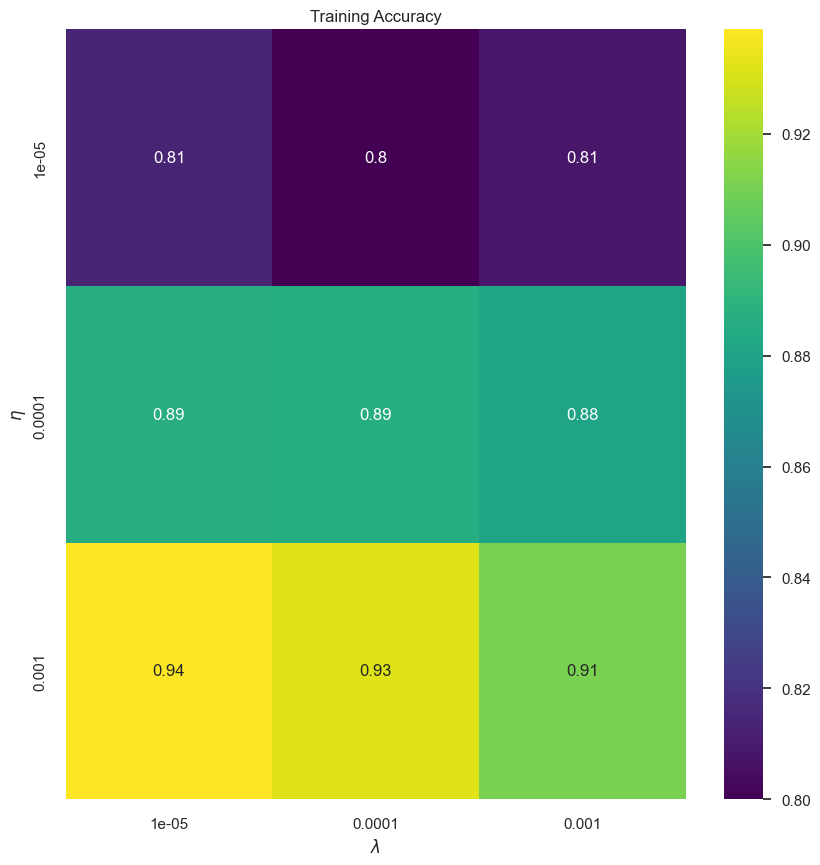

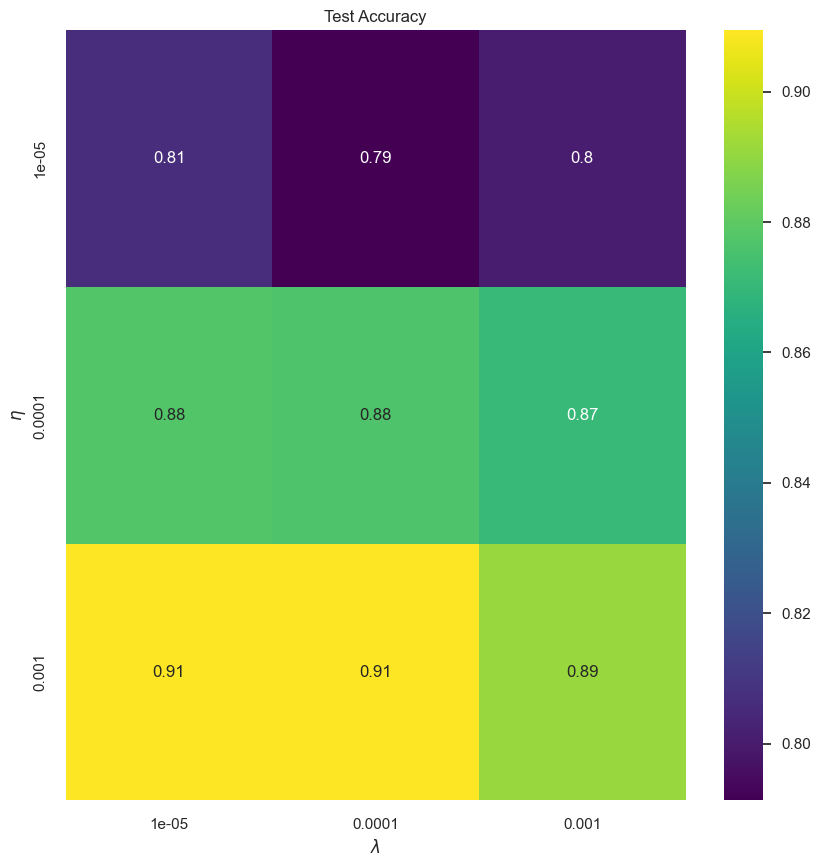

In [41]:
# Visual representation of grid search
sns.set_theme(style='darkgrid')

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_res[i][j]

        train_accuracy[i][j] = CNN.evaluate(train_images, train_labels)[1]
        test_accuracy[i][j] = CNN.evaluate(test_images, test_labels)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy,  annot=True, ax=ax, cmap='viridis',
            xticklabels=eta_vals, 
            yticklabels=lmbd_vals)
ax.set_title('Training Accuracy')
ax.set_ylabel('$\eta$')
ax.set_xlabel('$\lambda$')
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap='viridis', 
            xticklabels=eta_vals, 
            yticklabels=lmbd_vals)
ax.set_title('Test Accuracy')
ax.set_ylabel('$\eta$')
ax.set_xlabel('$\lambda$')
plt.show()


### Optimal model

Epoch 1/100
938/938 [==============================] - 32s 33ms/step - loss: 0.4690 - accuracy: 0.8417 - val_loss: 0.3815 - val_accuracy: 0.8768
Epoch 2/100
938/938 [==============================] - 29s 31ms/step - loss: 0.3307 - accuracy: 0.8954 - val_loss: 0.3835 - val_accuracy: 0.8786
Epoch 3/100
938/938 [==============================] - 29s 31ms/step - loss: 0.2950 - accuracy: 0.9092 - val_loss: 0.3304 - val_accuracy: 0.8931
Epoch 4/100
938/938 [==============================] - 32s 34ms/step - loss: 0.2710 - accuracy: 0.9176 - val_loss: 0.3066 - val_accuracy: 0.9082
Epoch 5/100
938/938 [==============================] - 31s 33ms/step - loss: 0.2584 - accuracy: 0.9251 - val_loss: 0.3048 - val_accuracy: 0.9119
Epoch 6/100
938/938 [==============================] - 32s 34ms/step - loss: 0.2437 - accuracy: 0.9311 - val_loss: 0.3156 - val_accuracy: 0.9108
Epoch 7/100
938/938 [==============================] - 31s 33ms/step - loss: 0.2340 - accuracy: 0.9354 - val_loss: 0.3182 - val_ac

Text(0.5, 1.0, 'Confusion Matrix (eta=0.001, lambda=0.0001)')

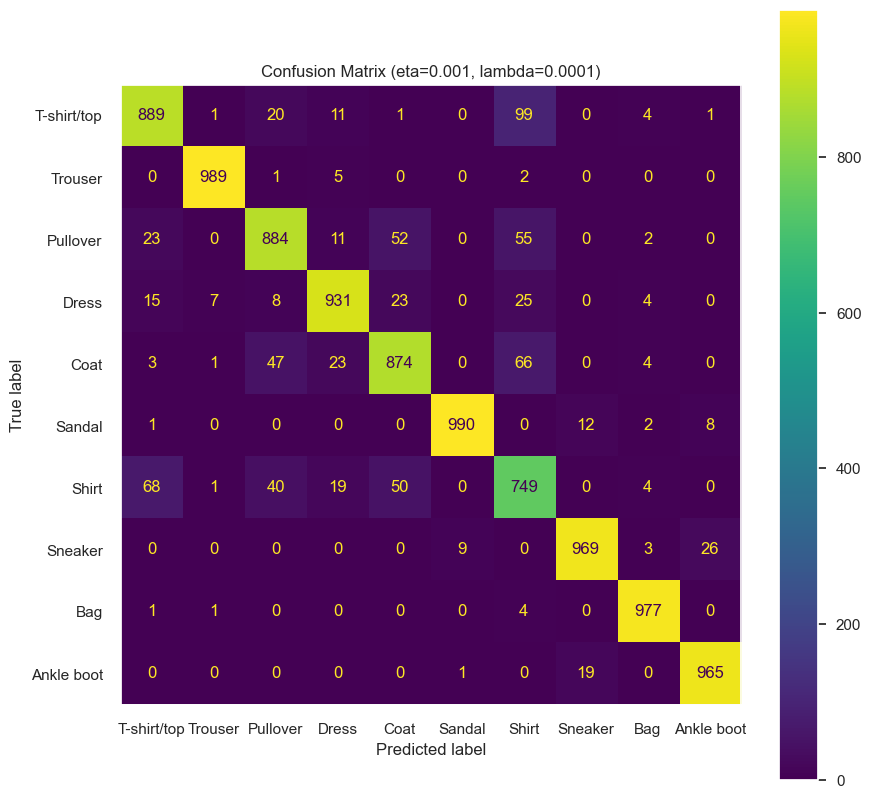

In [30]:
best_eta = 0.001
best_lambda = 0.0001

batch_size = 64 # Smaller batch size
epochs = 100 # More epochs

# Create early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,         
    restore_best_weights=True  
)

# Create and train model with optimal values
best_model = create_CNN(best_eta, best_lambda)
history_best = best_model.fit(train_images, train_labels, validation_split = 0.2, batch_size=batch_size,  
                    epochs=epochs, validation_data=(test_images, test_labels), 
                    callbacks=[early_stopping])

# Predict on test set
test_probabilities = best_model.predict(test_images)

# Convert prediction probability into integers 
test_predictions = test_probabilities.argmax(axis=1)

# Convert test_labels from one-hot encoding to class indices
test_labels_indices = test_labels.argmax(axis=1) 

# Confusion matrix
cm = confusion_matrix(test_predictions, test_labels_indices)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.grid(False)
plt.title(f'Confusion Matrix (eta={best_eta}, lambda={best_lambda})')


### Plot accuracy for optimal beta and lambda values

/var/folders/yw/7xk1wysd3kvfs513n3xmpn340000gn/T/ipykernel_85580/3838174932.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


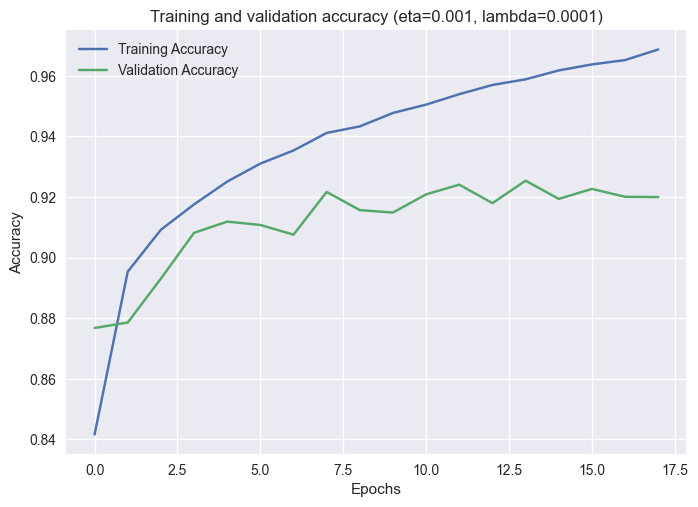

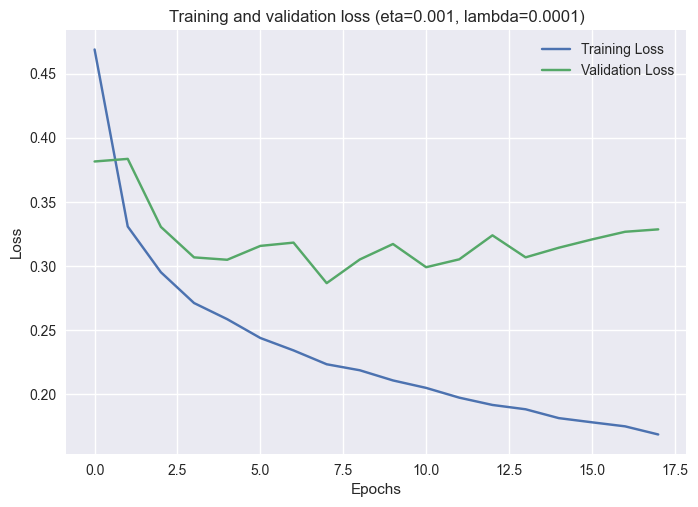

In [31]:
sns.set_theme(style="darkgrid")
plt.style.use('seaborn')


# Plot training and validation accuracy
plt.plot(history_best.history['accuracy'], label='Training Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and validation accuracy (eta={best_eta}, lambda={best_lambda})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title(f'Training and validation loss (eta={best_eta}, lambda={best_lambda})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Classification report

In [33]:
print(classification_report(test_labels_indices, test_predictions, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.87      0.89      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.86      0.87      0.87      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.80      0.75      0.78      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Predicting on an image

(28, 28, 1)


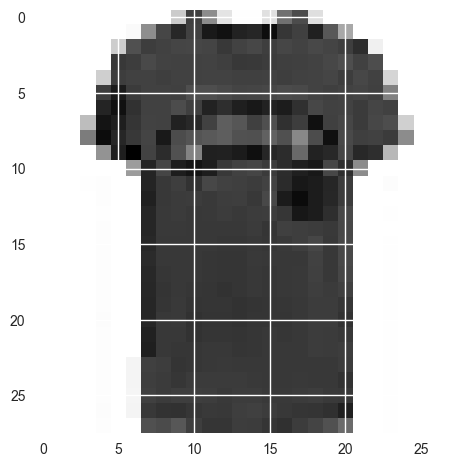

In [34]:
img = test_images[19]

print(img.shape)
plt.imshow(test_images[19], cmap=plt.cm.gray_r)

tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So, even though we are only using a single image, we need to add it to a list:

In [35]:
# Image in list
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28, 1)


In [36]:
predictions_single = best_model.predict(img)

print(np.argmax(predictions_single))
print(f'Predicted class: {class_names[np.argmax(predictions_single)]}')
print(f'True class: {class_names[np.argmax(test_labels[19])]}')

1/1 [==============================] - 0s 102ms/step
0
Predicted class: T-shirt/top
True class: T-shirt/top


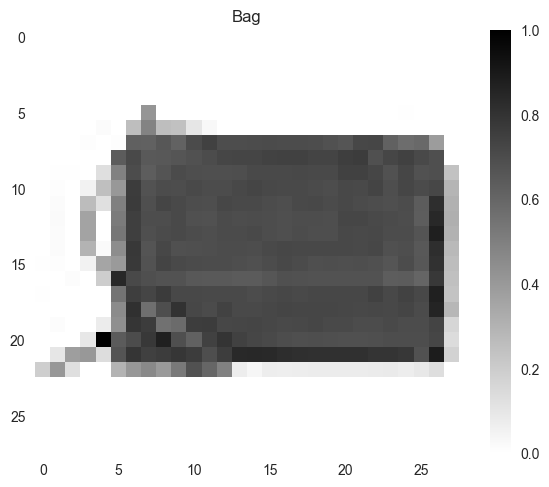

In [38]:
plt.figure()
plt.imshow(test_images[18], cmap=plt.cm.gray_r)
plt.title(f'{class_names[np.argmax(test_labels[18])]}')
plt.colorbar()
plt.grid(False)
plt.show()